### Batch culture setup and model growth assessment (FBA)
For a set of predefined media, uniformly set uptake boundaries and solve the FBA, outputting the optimal growth rate for each medium.
Negative control conditions, such as "mbm_nocarbon," ensure that the growth rate is zero to verify the model's purification effectiveness.

In [22]:
import pandas as pd
from cobra.io import read_sbml_model

MODEL = "hot5f3_gf_ATCC_pyr.xml"   
MEDIA_DB = "media.tsv"
MEDIA = ["mbm_glc__D","ATCC_glc__D","mbm_lac_D","ATCC_lac_D","mbm_pyr","ATCC_pyr","mbm_nocarbon","ATCC_nocarbon"]

df = pd.read_csv(MEDIA_DB, sep="\t")

def set_medium(m, name):
    # Turn off all ingestion
    for ex in m.exchanges:
        ex.lower_bound = 0.0
    # Open the specified culture medium
    items = df[df.medium==name]["compound"].tolist()
    for met in items:
        for rid in (f"EX_{met}_e", f"EX_{met}_D_e", f"EX_{met}_L_e"):
            if rid in m.reactions:
                m.reactions.get_by_id(rid).lower_bound = -10.0
                break

model = read_sbml_model(MODEL)
rows = []
for name in MEDIA:
    set_medium(model, name)
    sol = model.optimize()
    rows.append({"medium": name, "status": sol.status, "mu_per_h": sol.objective_value})
out = pd.DataFrame(rows)
print(out)
out.to_csv("gf_union_growth.tsv", sep="\t", index=False)

Adding exchange reaction EX_12ppd__R_e with default bounds for boundary metabolite: 12ppd__R_e.
Adding exchange reaction EX_23camp_e with default bounds for boundary metabolite: 23camp_e.
Adding exchange reaction EX_23ccmp_e with default bounds for boundary metabolite: 23ccmp_e.
Adding exchange reaction EX_23cgmp_e with default bounds for boundary metabolite: 23cgmp_e.
Adding exchange reaction EX_23cump_e with default bounds for boundary metabolite: 23cump_e.
Adding exchange reaction EX_25dkglcn_e with default bounds for boundary metabolite: 25dkglcn_e.
Adding exchange reaction EX_2m35mdntha_e with default bounds for boundary metabolite: 2m35mdntha_e.
Adding exchange reaction EX_35dnta_e with default bounds for boundary metabolite: 35dnta_e.
Adding exchange reaction EX_3amp_e with default bounds for boundary metabolite: 3amp_e.
Adding exchange reaction EX_3cmp_e with default bounds for boundary metabolite: 3cmp_e.
Adding exchange reaction EX_3mb_e with default bounds for boundary metab

          medium   status  mu_per_h
0     mbm_glc__D  optimal  2.400217
1    ATCC_glc__D  optimal  0.893079
2      mbm_lac_D  optimal  1.440130
3     ATCC_lac_D  optimal  0.703149
4        mbm_pyr  optimal  1.440130
5       ATCC_pyr  optimal  0.703149
6   mbm_nocarbon  optimal  0.000000
7  ATCC_nocarbon  optimal  0.000000


In [10]:
f = pd.read_csv("gf_union_growth.tsv")
f

,medium\tstatus\tmu_per_h
0,mbm_glc__D\toptimal\t2.400217152446231
1,ATCC_glc__D\toptimal\t0.8930785785012183
2,mbm_lac_D\toptimal\t1.4401302914677894
3,ATCC_lac_D\toptimal\t0.7031488576199332
4,mbm_pyr\toptimal\t1.4401302914677154
5,ATCC_pyr\toptimal\t0.7031488576208996
6,mbm_nocarbon\toptimal\t0.0
7,ATCC_nocarbon\toptimal\t0.0


### plot a heat map
Convert the FBA growth rate results (gf_union_growth.tsv) of mbm and ATCC with diffrent carbon sources medium and no carbon medium into a heat map of "Carbon Source × Culture Medium (MBM/ATCC)" to visually see the difference in growth ability of the model under different culture media/carbon sources using colors and values.


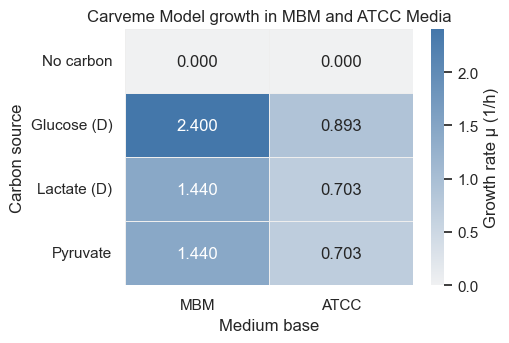

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

TSV = "gf_union_growth.tsv"  
df = pd.read_csv(TSV, sep="\t")

# Analysis of culture medium name: MBM/ATCC and carbon source type
def base_from_medium(m):
    s = str(m).lower()
    return "MBM" if s.startswith("mbm") else "ATCC"

def carbon_from_medium(m):
    s = str(m)
    if "_" in s:
        s = s.split("_", 1)[1]
    s = s.lower()
    if s in {"glc__d","glc_d","glc"}: return "Glucose (D)"
    if s in {"lac_d","lac","lactate_d"}: return "Lactate (D)"
    if s in {"pyr","pyruvate"}: return "Pyruvate"
    if s in {"nocarbon","noc","no_c","no-carbon"}: return "No carbon"
    return s
df["base"] = df["medium"].apply(base_from_medium)
df["carbon"] = df["medium"].apply(carbon_from_medium)
df["mu_per_h"] = pd.to_numeric(df["mu_per_h"], errors="coerce").fillna(0.0)

#Carbon source ranking
row_order = ["No carbon", "Glucose (D)", "Lactate (D)", "Pyruvate"]
col_order = ["MBM", "ATCC"]
df = df[df["carbon"].isin(row_order)]

# Generate heatmap matrix
mat = (df.pivot_table(index="carbon", columns="base", values="mu_per_h", aggfunc="max")
         .reindex(index=row_order, columns=col_order)
         .fillna(0.0))

# Draw a heat map: colors represent growth rates, and the values are marked in the cells
sns.set(style="white")
fig, ax = plt.subplots(figsize=(5.2, 3.6))
cmap = sns.light_palette("#4477AA", as_cmap=True)
g = sns.heatmap(mat, annot=True, fmt=".3f", cmap=cmap, cbar_kws={"label":"Growth rate μ (1/h)"},
                linewidths=0.5, linecolor="#EEEEEE", ax=ax, vmin=0, vmax=max(1e-9, mat.to_numpy().max()))
ax.set_xlabel("Medium base")
ax.set_ylabel("Carbon source")
ax.set_title("Carveme Model growth in MBM and ATCC Media")
plt.tight_layout()
plt.savefig('Model_growth_across_media.png', dpi=300)
plt.show()



### Audit which reactions were added to the gapfilling of each culture medium
Read my CarveMe draft model output.xml and retrieve its reaction set raw_rxn.Read each "medium × carbon source" model (mbm/ATCC × glc_D, lac_D, pyr) in turn.

For each model, identify the "unseen" reactions (compared to the draft model plus those already seen in previous steps). Record these reactions in rows, recording their name, subsystem, and GPR. 

Output gapfill_added_reactions.tsv.

In [ ]:
from cobra.io import read_sbml_model
import pandas as pd

steps = [
    ("hot5f3_gf_mbm_glc__D.xml","mbm_glc__D"),
    ("hot5f3_gf_ATCC_glc__D.xml","ATCC_glc__D"),
    ("hot5f3_gf_mbm_lac_D.xml","mbm_lac_D"),
    ("hot5f3_gf_ATCC_lac_D.xml","ATCC_lac_D"),
    ("hot5f3_gf_mbm_pyr.xml","mbm_pyr"),
    ("hot5f3_gf_ATCC_pyr.xml","ATCC_pyr"),
]

raw = read_sbml_model("output.xml")
prev = raw
rows = []
for path, tag in steps:
    cur = read_sbml_model(path)
    prev_ids = {r.id for r in prev.reactions}
    cur_ids  = {r.id for r in cur.reactions}
    added = cur_ids - prev_ids
    removed = prev_ids - cur_ids
    for r in cur.reactions:
        if r.id in added:
            rows.append({"step": tag, "change": "added", "rxn_id": r.id,
                         "name": r.name, "subsystem": getattr(r, "subsystem", ""),
                         "gpr": r.gene_reaction_rule or ""})
    for rid in removed:
        r = prev.reactions.get_by_id(rid)
        rows.append({"step": tag, "change": "removed", "rxn_id": rid,
                     "name": r.name, "subsystem": getattr(r, "subsystem", ""),
                     "gpr": r.gene_reaction_rule or ""})
    prev = cur

pd.DataFrame(rows).to_csv("gapfill_step_deltas.tsv", sep="\t", index=False)
print("logged to gapfill_step_deltas.tsv")

Adding exchange reaction EX_12ppd__R_e with default bounds for boundary metabolite: 12ppd__R_e.
Adding exchange reaction EX_23camp_e with default bounds for boundary metabolite: 23camp_e.
Adding exchange reaction EX_23ccmp_e with default bounds for boundary metabolite: 23ccmp_e.
Adding exchange reaction EX_23cgmp_e with default bounds for boundary metabolite: 23cgmp_e.
Adding exchange reaction EX_23cump_e with default bounds for boundary metabolite: 23cump_e.
Adding exchange reaction EX_25dkglcn_e with default bounds for boundary metabolite: 25dkglcn_e.
Adding exchange reaction EX_2m35mdntha_e with default bounds for boundary metabolite: 2m35mdntha_e.
Adding exchange reaction EX_35dnta_e with default bounds for boundary metabolite: 35dnta_e.
Adding exchange reaction EX_3amp_e with default bounds for boundary metabolite: 3amp_e.
Adding exchange reaction EX_3cmp_e with default bounds for boundary metabolite: 3cmp_e.
Adding exchange reaction EX_3mb_e with default bounds for boundary metab

change      added_n
step               
mbm_glc__D       27
ATCC_lac_D        3


/var/folders/zf/djxp3yw111l48637pbxfwcy00000gn/T/ipykernel_1655/1930634977.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["step", "change"])


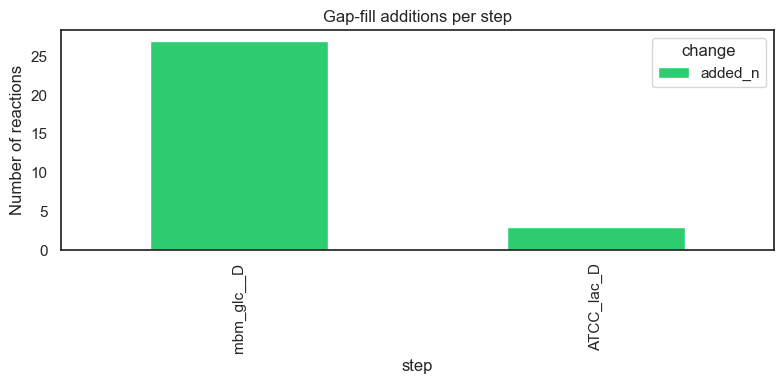

In [36]:

# Read the gap-fill delta log (tab-separated).
# Each row represents a reaction that was either "added" or "removed"
# when moving from the previous model to the current step/model.
df = pd.read_csv("gapfill_step_deltas.tsv", sep="\t")

# Determine the step order as it appears in the file.
# drop_duplicates() preserves the first occurrence order,
# which we then use as the categorical order for plotting and grouping.
step_order = list(df["step"].drop_duplicates())

# Make 'step' an ordered categorical so groupby/plot keep this order
# (otherwise steps may be sorted alphabetically).
df["step"] = pd.Categorical(df["step"], categories=step_order, ordered=True)

# 1) Per-step counts of added/removed reactions
# - groupby(["step","change"]).size() counts rows in each (step, change) bin.
# - unstack() pivots "change" values (added/removed) to columns.
# - fill_value=0 ensures missing combinations appear as 0 (e.g., no removals at a step).
# - rename the columns to clearer names (added_n / removed_n).
cnt = (
    df.groupby(["step", "change"])
      .size()
      .unstack(fill_value=0)
      .rename(columns={"added": "added_n", "removed": "removed_n"})
)

# Print the table to inspect raw counts before plotting.
print(cnt)

# 2) Visualization
# Plot a grouped bar chart where each step has:
# - a green bar for the number of added reactions,
# - a red bar for the number of removed reactions.
# Using DataFrame.plot keeps index (steps) on the x-axis and columns as series.
ax = cnt.plot(
    kind="bar",
    figsize=(8, 4),
    color={"added_n": "#2ECC71", "removed_n": "#E74C3C"},
)

# Axis labels and title
ax.set_ylabel("Number of reactions")
ax.set_title("Gap-fill additions per step")

# Improve layout to avoid label overlap/cutoffs
plt.tight_layout()
plt.savefig('carveme_model_Gap-fill_additions.png', dpi=300)
# Render the figure
plt.show()


In [40]:

df = pd.read_csv("gapfill_step_deltas.tsv", sep="\t")
for step in ["mbm_glc__D","ATCC_lac_D"]:
    sub = df[(df.step==step) & (df.change=="added")]
    print(step, "added reactions:")
    print(sub[["rxn_id","name","subsystem","gpr"]].to_string(index=False))

mbm_glc__D added reactions:
     rxn_id                                                     name  subsystem  gpr
 EX_4hptn_e                                               EX_4hptn_e        NaN  NaN
   EX_fol_e                                                 EX_fol_e        NaN  NaN
  EX_ncam_e                                                EX_ncam_e        NaN  NaN
EX_ribflv_e                                              EX_ribflv_e        NaN  NaN
     4HBADH                   4 hydroxy benzyl alcohol dehydrogenase        NaN  NaN
  4HPTNCOAL                           4 Hydroxypentanoate CoA ligase        NaN  NaN
   4HPTNtex              4 Hydroxypentanoate transport via diffusion        NaN  NaN
   4HPTNtpp             4 Hydroxypentanoate transport via Na symport        NaN  NaN
   5HBZIDMT                 5-hydroxybenzimidazole methyltransferase        NaN  NaN
   5HBZIDS2                          5-hydroxybenzimidazole synthase        NaN  NaN
     AHMMPS    4 amino 5 hydroxymethy

### analysis of gapfill_step_deltas
mbm_glc__D (mbm_glu):
Under the minimal MBM medium with only glucose supplied, the model had to add many reactions to satisfy biomass demands for cofactors/vitamins and respiratory cofactors. Most additions are exchange and transport chains for compounds like riboflavin, folate, and nicotinamide (EX_* plus corresponding tex/t2 transporters), together with biosynthetic steps (e.g., thiamine/thiazole ring, ubiquinone precursors, heme, etc.). Many entries lack GPR, suggesting orphan gap-fills that compensate for missing annotations or assume external supply. Whether to keep uptake or instead complete de novo synthesis should be decided based on the actual medium composition.

ATCC_lac_D:
With the richer ATCC medium using lactate as the carbon source, only a few reactions were added—the essentials for lactate utilization: lactate exchange (EX_lac__D_e), a proton symport transporter (D_LACt2), and an oxidation step linked to lactate/glyoxylate handling (e.g., GLYOX2). The small number of additions indicates that ATCC and prior steps already met most cofactor requirements; the remaining bottleneck was substrate-specific transport and the first oxidative conversion needed to route lactate into central metabolism.